(30000, 25)
0    23364
1     6636
Name: default.payment.next.month, dtype: int64


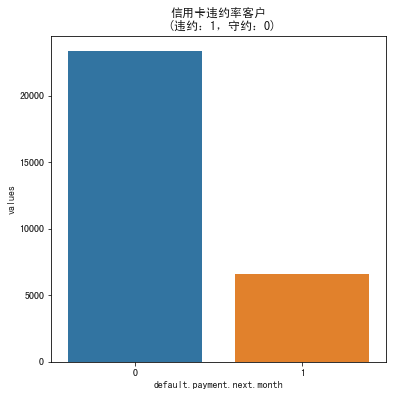

GridSearch 最优参数： {'svc__C': 1, 'svc__gamma': 0.01}
GridSearch 最优分数： 0.8174
 准确率 0.8172
GridSearch 最优参数： {'decisiontreeclassifier__max_depth': 6}
GridSearch 最优分数： 0.8186
 准确率 0.8113
GridSearch 最优参数： {'randomforestclassifier__n_estimators': 10}
GridSearch 最优分数： 0.8047
 准确率 0.8049


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# 信用卡违约率分析
#导入pandas包
import pandas as pd
#导入学习曲线函数、训练数据分离函数、参数自动搜索模块函数
from sklearn.model_selection import learning_curve, train_test_split, GridSearchCV
#计算均值、标准差
from sklearn.preprocessing import StandardScaler
#使用PCA方法对数据进行降维
from sklearn.decomposition import PCA
#导入管道机制进行流水作业
from sklearn.pipeline import Pipeline
#导入自带的评估模型准确率的函数
from sklearn.metrics import accuracy_score
#导入分类算法SVC， 其它还有NuSVC，和LinearSVC 。另一类是回归算法库，包括SVR， NuSVR，和LinearSVR 
from sklearn.svm import SVC
#决策树分类器
from sklearn.tree import DecisionTreeClassifier
#随机森林分类器
from sklearn.ensemble import RandomForestClassifier
#KNN分类器
from sklearn.neighbors import KNeighborsClassifier
#Adaboost分类器
from sklearn.ensemble import AdaBoostClassifier
#使用matplotlib绘图
from matplotlib import pyplot as plt
#使用seaborn绘图
import seaborn as sns

# 数据加载
data =pd.read_csv('./UCI_Credit_Card.csv')
# 数据探索
# 查看数据集大小
print(data.shape)
# 数据集概览
#print(data.describe()) 
# 查看下一个月违约率的情况(default.payment.next.month这一列取值的数量)
next_month = data['default.payment.next.month'].value_counts()
print(next_month)
df = pd.DataFrame({'default.payment.next.month': next_month.index,'values': next_month.values})
#用来正常显示中文标签（需要安装字库）
plt.rcParams['font.sans-serif']=['SimHei'] 
#设置画纸大小
plt.figure(figsize = (6,6))
plt.title('信用卡违约率客户\n (违约：1，守约：0)')
sns.set_color_codes("pastel")
sns.barplot(x = 'default.payment.next.month', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

# 特征选择，去掉 ID 字段(这个字段没用,不能作为特征)、最后一个结果字段（这个是作为标识）,剩余24列
data.drop(['ID'], inplace=True, axis =1) 
#最后一列是作为标识
target = data['default.payment.next.month'].values
#列表：23个特征和1个标识
columns = data.columns.tolist()

#列表：23个特征
columns.remove('default.payment.next.month')
#只有23个特征的DataFrame
features = data[columns].values
# 30% 作为测试集，其余作为训练集
# random_state = 1表示重复试验随机得到的数据集始终不变
# stratify = target 表示按标识的类别，作为训练数据集、测试数据集内部的分配比例
train_x, test_x, train_y, test_y = train_test_split(features, target, test_size=0.30, stratify = target, random_state = 1)

# 构造各种分类器
classifiers = [
    SVC(random_state = 1, kernel = 'rbf'),    
    DecisionTreeClassifier(random_state = 1, criterion = 'gini'),
    RandomForestClassifier(random_state = 1, criterion = 'gini'),
    KNeighborsClassifier(metric = 'minkowski'),
    AdaBoostClassifier(random_state = 1)
]
# 分类器名称
classifier_names = [
            'svc', 
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'adaboostclassifier'
]
# 分类器参数
#注意分类器的参数，字典键的格式，GridSearchCV对调优的参数格式是"分类器名"+"__"+"参数名"
classifier_param_grid = [
            {'svc__C':[1], 'svc__gamma':[0.01]},
            {'decisiontreeclassifier__max_depth':[6,9,11]},
            {'randomforestclassifier__n_estimators':range(1,11)} ,
            {'kneighborsclassifier__n_neighbors':[4,6,8]},
            {'adaboostclassifier__n_estimators':[10,50,100]}
]


# 对具体的分类器进行 GridSearchCV 参数调优
def GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, param_grid, score = 'accuracy_score'):
    response = {}
    gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv=3, scoring = score)
    # 寻找最优的参数 和最优的准确率分数
    search = gridsearch.fit(train_x, train_y)
    print("GridSearch 最优参数：", search.best_params_)
    print("GridSearch 最优分数： %0.4lf" %search.best_score_)
    #采用predict函数（特征是测试数据集）来预测标识，预测使用的参数是上一步得到的最优参数
    predict_y = gridsearch.predict(test_x)
    print(" 准确率 %0.4lf" %accuracy_score(test_y, predict_y))
    response['predict_y'] = predict_y
    response['accuracy_score'] = accuracy_score(test_y,predict_y)
    return response
 
for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    #采用 StandardScaler 方法对数据规范化：均值为0，方差为1的正态分布
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            #('pca',PCA),
            (model_name, model)
    ])
    result = GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, model_param_grid , score = 'accuracy')